# 乖離率策略

## 交易邏輯
乖離率為當期股價與均線的垂直距離。
* 當距離正越大時，股價出現反轉機會上升，應當賣出。
* 當距離負越大時，股價出現反轉機會上升，應當買入。

## 交易策略
加入收盤價與過去最高低價格比較做為第二層濾網。
* 若收盤價低於過去 7 天的最低價，同時出現負乖離時，隔日開盤買入。
* 若收盤價高於過去 7 天最最高價，同時出現正乖離時，隔日開盤賣出。

## 參考來源
[官網文章: 乖離率策略]:https://www.tejwin.com/insight/%E4%B9%96%E9%9B%A2%E7%8E%87%E4%BA%A4%E6%98%93%E7%AD%96%E7%95%A5/
[官網文章: 乖離率策略]

## 導入資料與套件

資料導入階段，我們使用 `os.environ` 設置環境變數，分別設定:

1. TEJAPI_BASE: 設定 tej api 網域名稱。
2. TEJAPI_KEY: 為購買 TQuant Lab 隨附的 api key，用於驗證個人身分。
3. mdate: 所欲抓取資料的時間範圍，格式為 "西元年份月份日期 西元年份月份日期"。
4. ticker: 所欲抓取資料的股價代碼。

於本次案例我們抓取台積電資料，時間區間設定為 2005-07-02 到 2023-07-02 之間。

In [1]:
import os
import pandas as pd
import numpy as np 
import tejapi
import matplotlib.pyplot as plt

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'your key' 
os.environ['mdate'] = '20050702 20230702'
os.environ['ticker'] = '2330'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 516/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 61121197/9223372036854775807 (0.0%)


[2024-02-07 03:35:10.490051] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-07 03:35:14.476018] INFO: zipline.data.bundles.core: Ingest tquant successfully.


## 編輯交易策略

### 導入所需套件

In [2]:
from zipline.api import (set_slippage, 
                         set_commission, 
                         set_benchmark, 
                         attach_pipeline, 
                         symbol, 
                         pipeline_output,
                         record, 
                         order,
                         order_target
                        )
from zipline.pipeline.filters import StaticSids
from zipline.finance import slippage, commission
from zipline import run_algorithm
from zipline.pipeline import CustomFactor, Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import ExponentialWeightedMovingAverage

### 建立 Pipeline 函式

`Pipeline()` 提供使用者快速處理多檔標的的量化指標與價量資料的功能，於本次案例我們用以處理:

* 股價的 7 日指數移動平均
* 過去 7 日的股價最高價 (自定義 factor 函式: `NdaysMaxHigh`)
* 過去 7 日的股價最低價 (自定義 factor 函式: `NdaysMinLow`)
* 當日收盤價


In [3]:
def make_pipeline():
    ema = ExponentialWeightedMovingAverage(inputs = [EquityPricing.close],window_length = 7,decay_rate = 1/7)
    high = NdaysMaxHigh(inputs = [EquityPricing.close], window_length = 8) # window_length 設定為 8，因為 factor 會包含當日價格。
    low = NdaysMinLow(inputs = [EquityPricing.close], window_length = 8)
    close = EquityPricing.close.latest
    return Pipeline(
        columns = {
            'ema':ema,
            'highesthigh':high,
            'lowestlow':low,
            'latest':close
        }
    )
class NdaysMaxHigh(CustomFactor):
    def compute(self, today, assets, out, data):
        out[:] = np.nanmax(data[:-2], axis=0)
class NdaysMinLow(CustomFactor):
    def compute(self, today, assets, out, data):
        out[:] = np.nanmin(data[:-2], axis=0)

### 建立 initialize 函式

`inintialize` 函式用於定義交易開始前的每日交易環境，與此例中我們設置:

* 流動性滑價
* 交易手續費
* 買入持有台積電的報酬作為基準
* 將 Pipeline 導入交易流程中

In [4]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('2330'))
    attach_pipeline(make_pipeline(), 'mystrategy')

### 建立 handle_date 函式

`handle_data` 函式用於處理每天的交易策略或行動，其中:

* condition1: 當日收盤價大於過去 7 日最高價且產生正乖離時，產生賣出訊號。
* condition2: 當日收盤價小於過去 7 日最低價且產生負乖離時，產生買入訊號。

In [5]:
def handle_data(context, data):
    
    pipe = pipeline_output('mystrategy')
    
    for i in pipe.index:
        ema = pipe.loc[i, 'ema']
        highesthigh = pipe.loc[i, 'highesthigh']
        lowestlow = pipe.loc[i, 'lowestlow']
        close = pipe.loc[i, 'latest']
        bias = close - ema
        residual_position = context.portfolio.positions[i].amount # 當日該資產的股數
        condition1 = (close > highesthigh) and (bias > 0) and (residual_position > 0) # 賣出訊號
        condition2 = (close < lowestlow) and (bias < 0) # 買入訊號
        
        record( # 用以紀錄以下資訊至最終產出的 result 表格中
            con1 = condition1,
            con2 = condition2,
            price = close,
            ema = ema,
            bias = bias,
            highesthigh = highesthigh,
            lowestlow = lowestlow
        )
    
        if condition1:
            order_target(i, 0)
        elif condition2:
            order(i, 10)
        else:
            pass

### 建立 analyze 函式

多半用於繪製績效圖表，於本案例使用 matplotlib 將視覺化買賣點與投組價值變化。

In [6]:
import matplotlib.pyplot as plt
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Price (NTD)")
    perf.price.plot(ax=ax2)
    ax2.plot( # 繪製買入訊號
        perf.index[perf.con2],
        perf.loc[perf.con2, 'price'],
        '^',
        markersize=5,
        color='red'
    )
    ax2.plot( # 繪製賣出訊號
        perf.index[perf.con1],
        perf.loc[perf.con1, 'price'],
        'v',
        markersize=5,
        color='green'
    )
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18,8)
    plt.show()

## 執行交易策略

使用 `run_algorithm` 執行上述所編撰的交易策略，設置交易期間為 2015-01-05 到 2022-07-02，所使用資料集為 *tquant*，初始資金為 10,000 元。其中輸出的 __results__ 就是每日績效與交易的明細表。

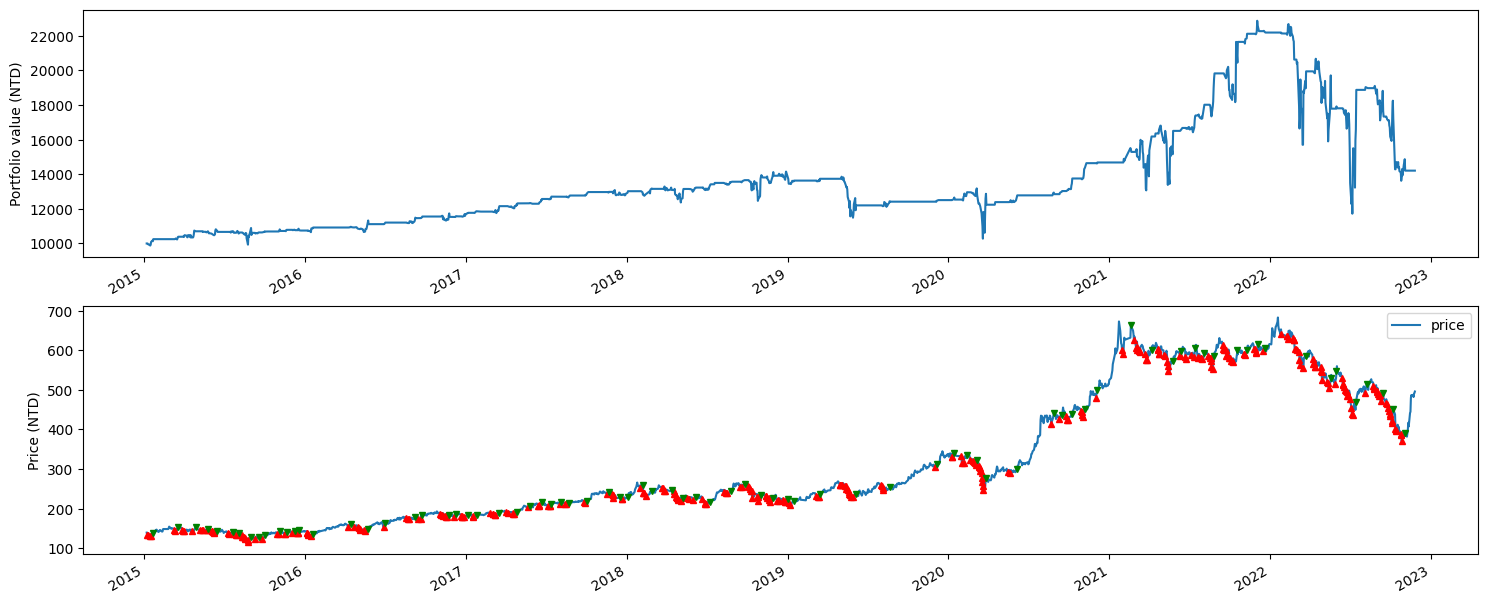

In [7]:
results = run_algorithm(start = pd.Timestamp('20150106', tz='UTC'),
                       end = pd.Timestamp('20221125', tz='UTC'),
                       initialize=initialize,
                       bundle='tquant',
                       analyze=analyze,
                       capital_base=1e4,
                       handle_data = handle_data
                      )

In [8]:
results # 績效與交易明細

,period_open,period_close,starting_cash,ending_cash,capital_used,portfolio_value,longs_count,pnl,positions,shorts_count,...,max_drawdown,max_leverage,trading_days,period_label,benchmark_period_return,excess_return,benchmark_volatility,algo_volatility,treasury_period_return,algorithm_period_return
2015-01-06 13:30:00+08:00,2015-01-06 09:01:00+08:00,2015-01-06 13:30:00+08:00,10000.000000,10000.000000,0.0000,10000.000000,0,0.0000,[],0,...,0.000000,0.000000,1,2015-01,-0.043009,0.043009,NaN,NaN,0.0,0.000000
2015-01-07 13:30:00+08:00,2015-01-07 09:01:00+08:00,2015-01-07 13:30:00+08:00,10000.000000,10000.000000,0.0000,10000.000000,0,0.0000,[],0,...,0.000000,0.000000,2,2015-01,-0.039429,0.039429,0.524768,0.000000,0.0,0.000000
2015-01-08 13:30:00+08:00,2015-01-08 09:01:00+08:00,2015-01-08 13:30:00+08:00,10000.000000,8619.971500,-1380.0285,9999.971500,1,-0.0285,"[{'sid': Equity(0 [2330]), 'amount': 10, 'cost...",0,...,-0.000003,0.138000,3,2015-01,-0.010750,0.010747,0.586026,0.000026,0.0,-0.000003
2015-01-09 13:30:00+08:00,2015-01-09 09:01:00+08:00,2015-01-09 13:30:00+08:00,8619.971500,7279.943000,-1340.0285,9959.943000,1,-40.0285,"[{'sid': Equity(0 [2330]), 'amount': 20, 'cost...",0,...,-0.004006,0.269078,4,2015-01,-0.039429,0.035423,0.520633,0.031764,0.0,-0.004006
2015-01-12 13:30:00+08:00,2015-01-12 09:01:00+08:00,2015-01-12 13:30:00+08:00,7279.943000,7279.943000,0.0000,9919.943000,1,-40.0000,"[{'sid': Equity(0 [2330]), 'amount': 20, 'cost...",0,...,-0.008006,0.269078,5,2015-01,-0.053759,0.045753,0.452459,0.034854,0.0,-0.008006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21 13:30:00+08:00,2022-11-21 09:01:00+08:00,2022-11-21 13:30:00+08:00,14205.790999,14205.790999,0.0000,14205.790999,0,0.0000,[],0,...,-0.487303,4.620656,1928,2022-11,3.424819,-3.004240,0.252670,0.298093,0.0,0.420579
2022-11-22 13:30:00+08:00,2022-11-22 09:01:00+08:00,2022-11-22 13:30:00+08:00,14205.790999,14205.790999,0.0000,14205.790999,0,0.0000,[],0,...,-0.487303,4.620656,1929,2022-11,3.507440,-3.086861,0.252686,0.298016,0.0,0.420579
2022-11-23 13:30:00+08:00,2022-11-23 09:01:00+08:00,2022-11-23 13:30:00+08:00,14205.790999,14205.790999,0.0000,14205.790999,0,0.0000,[],0,...,-0.487303,4.620656,1930,2022-11,3.516621,-3.096042,0.252621,0.297939,0.0,0.420579
2022-11-24 13:30:00+08:00,2022-11-24 09:01:00+08:00,2022-11-24 13:30:00+08:00,14205.790999,14205.790999,0.0000,14205.790999,0,0.0000,[],0,...,-0.487303,4.620656,1931,2022-11,3.553341,-3.132762,0.252569,0.297861,0.0,0.420579


# 績效評估與視覺化

In [9]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

### 交易策略投組報酬率

In [10]:
returns

2015-01-06 00:00:00+00:00    0.000000
2015-01-07 00:00:00+00:00    0.000000
2015-01-08 00:00:00+00:00   -0.000003
2015-01-09 00:00:00+00:00   -0.004003
2015-01-12 00:00:00+00:00   -0.004016
                               ...   
2022-11-21 00:00:00+00:00    0.000000
2022-11-22 00:00:00+00:00    0.000000
2022-11-23 00:00:00+00:00    0.000000
2022-11-24 00:00:00+00:00    0.000000
2022-11-25 00:00:00+00:00    0.000000
Name: returns, Length: 1932, dtype: float64

### 交易策略部位數量

In [11]:
positions

sid,Equity(0 [2330]),cash
index,,
2015-01-08 00:00:00+00:00,1380.0,8619.971500
2015-01-09 00:00:00+00:00,2680.0,7279.943000
2015-01-12 00:00:00+00:00,2640.0,7279.943000
2015-01-13 00:00:00+00:00,2650.0,7279.943000
2015-01-14 00:00:00+00:00,3900.0,5979.914500
...,...,...
2022-10-27 00:00:00+00:00,23130.0,-8834.038001
2022-10-28 00:00:00+00:00,22770.0,-8834.038001
2022-10-31 00:00:00+00:00,23400.0,-8834.038001


### 交易策略交易紀錄

In [12]:
transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2015-01-08 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),138.0,80c170abd9f6465695574fcaafc35397,10,None,2015-01-08 13:30:00+08:00,-1380.0
2015-01-09 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),134.0,6ffac82b7aa94fd7ad2daca3de2537c8,10,None,2015-01-09 13:30:00+08:00,-1340.0
2015-01-14 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),130.0,6c5a7adeca254c7e9564f65d3a78cca5,10,None,2015-01-14 13:30:00+08:00,-1300.0
2015-01-16 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),137.0,80e996fb0d65445eaa67bcdc08583f0b,10,None,2015-01-16 13:30:00+08:00,-1370.0
2015-01-21 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),141.0,0529b0a8abea448f8e42116dd271afc4,-40,None,2015-01-21 13:30:00+08:00,5640.0
...,...,...,...,...,...,...,...,...
2022-10-17 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),397.0,a735d20be6d64140af141b49a38e017d,10,None,2022-10-17 13:30:00+08:00,-3970.0
2022-10-25 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),371.0,33c145e7f29b4473a30011f2705cb967,10,None,2022-10-25 13:30:00+08:00,-3710.0
2022-10-26 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),376.0,1cfd9c299ebd402aaf96030fb6ecfa02,10,None,2022-10-26 13:30:00+08:00,-3760.0
2022-10-27 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),385.5,9828c96c67b941ada9b762c57c1cc9bb,10,None,2022-10-27 13:30:00+08:00,-3855.0


## 視覺化與績效評估

### 生成 pyfolio 所需資料表

之後我們使用 pyfolio 進行績效視覺化與評估，首先使用 `extract_rets_pos_txn_from_zipline()` 先將上述的 __results__ 資料表細分成以下部分:

* return: 投組每日報酬
* positions: 持有部位資料表
* transactions: 交易明細資料表

In [13]:
benchmark_rets = results['benchmark_return'] 
from pyfolio.utils import extract_rets_pos_txn_from_zipline
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

In [14]:
returns.head()

2015-01-06 00:00:00+00:00    0.000000
2015-01-07 00:00:00+00:00    0.000000
2015-01-08 00:00:00+00:00   -0.000003
2015-01-09 00:00:00+00:00   -0.004003
2015-01-12 00:00:00+00:00   -0.004016
Name: returns, dtype: float64

In [15]:
positions.head()

sid,Equity(0 [2330]),cash
index,,
2015-01-08 00:00:00+00:00,1380.0,8619.9715
2015-01-09 00:00:00+00:00,2680.0,7279.9430
2015-01-12 00:00:00+00:00,2640.0,7279.9430
2015-01-13 00:00:00+00:00,2650.0,7279.9430
2015-01-14 00:00:00+00:00,3900.0,5979.9145


In [16]:
transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2015-01-08 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),138.0,80c170abd9f6465695574fcaafc35397,10,None,2015-01-08 13:30:00+08:00,-1380.0
2015-01-09 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),134.0,6ffac82b7aa94fd7ad2daca3de2537c8,10,None,2015-01-09 13:30:00+08:00,-1340.0
2015-01-14 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),130.0,6c5a7adeca254c7e9564f65d3a78cca5,10,None,2015-01-14 13:30:00+08:00,-1300.0
2015-01-16 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),137.0,80e996fb0d65445eaa67bcdc08583f0b,10,None,2015-01-16 13:30:00+08:00,-1370.0
2015-01-21 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),141.0,0529b0a8abea448f8e42116dd271afc4,-40,None,2015-01-21 13:30:00+08:00,5640.0


### 製作投資績效表

使用 `show_perf_stats()` 製作績效表，可以快速計算投資常用績效與風險指標。

In [17]:
import pyfolio as pf 
perf_stats = pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2015-01-06
End date,2022-11-25
Total months,92
,Backtest
Annual return,4.686%
Cumulative returns,42.058%
Annual volatility,29.778%
Sharpe ratio,0.30
Calmar ratio,0.10
Stability,0.71
Max drawdown,-48.73%


### 繪製基準 (benchmark) 與投組累積報酬率

使用 `plot_rolling_returns()` 繪製，本案例的基準為台積電買入持有。

<AxesSubplot:ylabel='Cumulative returns'>

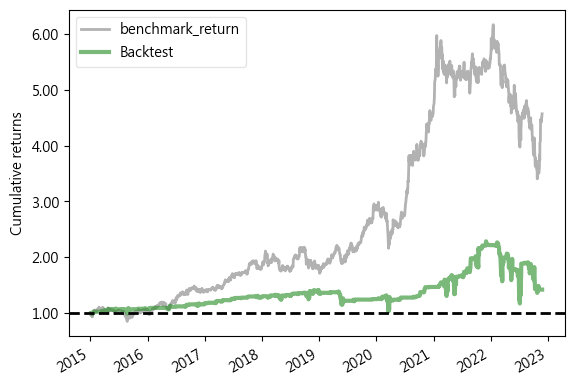

In [18]:
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)